In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
def find_convexity_arbitrage(ticker_symbol, delta_threshold=0.01):
    ticker = yf.Ticker(ticker_symbol)
    expiration = ticker.options[0]  # Get the closest option chain
    option_chain = ticker.option_chain(expiration)
    calls = option_chain.calls
    puts = option_chain.puts
    
    current_price = ticker.info['currentPrice']
    for dd in [calls,puts]:
        dd = dd.sort_values('strike')
        dd['price_diff'] = dd['ask'].diff()
        dd['strike_diff'] = dd['strike'].diff()
    
        dd['delta'] = dd['price_diff'] / dd['strike_diff']
    
        dd['gamma'] = dd['delta'].diff() / dd['strike_diff']

    def Linear_equation(x1,y1,x2,y2):
        M = (y2-y1)/(x2-x1)
        y0 = -M*x1 + y1
        return M, y0
    def Find_opportunities(df_cp):
        opportunities = []
        for i in range(1, len(df_cp) - 1):
            lower_strike = df_cp.iloc[i-1]
            middle_strike = df_cp.iloc[i]
            upper_strike = df_cp.iloc[i+1]

            slope, y_intersection = Linear_equation(upper_strike['strike'], upper_strike['ask'], lower_strike['strike'], lower_strike['ask'])
            expected_price = slope*middle_strike['strike'] + y_intersection
            actual_price = middle_strike['ask']
        
            if actual_price > expected_price*(1 + delta_threshold):
                opportunities.append({
                    'lower_strike': lower_strike['strike'],
                    'middle_strike': middle_strike['strike'],
                    'upper_strike': upper_strike['strike'],
                    'expected_price': expected_price,
                    'actual_price': actual_price,
                    'arbitrage': actual_price - expected_price
                })
        return opportunities
    opportunities_call = Find_opportunities(calls)
    opportunities_put = Find_opportunities(puts)
    
    opportunities_call_df = pd.DataFrame(opportunities_call)
    opportunities_put_df = pd.DataFrame(opportunities_call)
    
    # Plot call
    plt.figure(figsize=(12, 6))
    plt.plot(calls['strike'], calls['ask'], 'b-', label='Option Prices')
    if not opportunities_call_df.empty:
        plt.scatter(opportunities_call_df['middle_strike'], opportunities_call_df['actual_price'], 
                    color='r', s=50, label='Arbitrage Opportunities')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title(f'Convexity Arbitrage Opportunities for {ticker_symbol}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot put
    plt.figure(figsize=(12, 6))
    plt.plot(puts['strike'], puts['ask'], 'b-', label='Option Prices')
    if not opportunities_put_df.empty:
        plt.scatter(opportunities_put_df['middle_strike'], opportunities_put_df['actual_price'], 
                    color='r', s=50, label='Arbitrage Opportunities')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title(f'Convexity Arbitrage Opportunities for {ticker_symbol}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return opportunities_call_df, opportunities_put_df

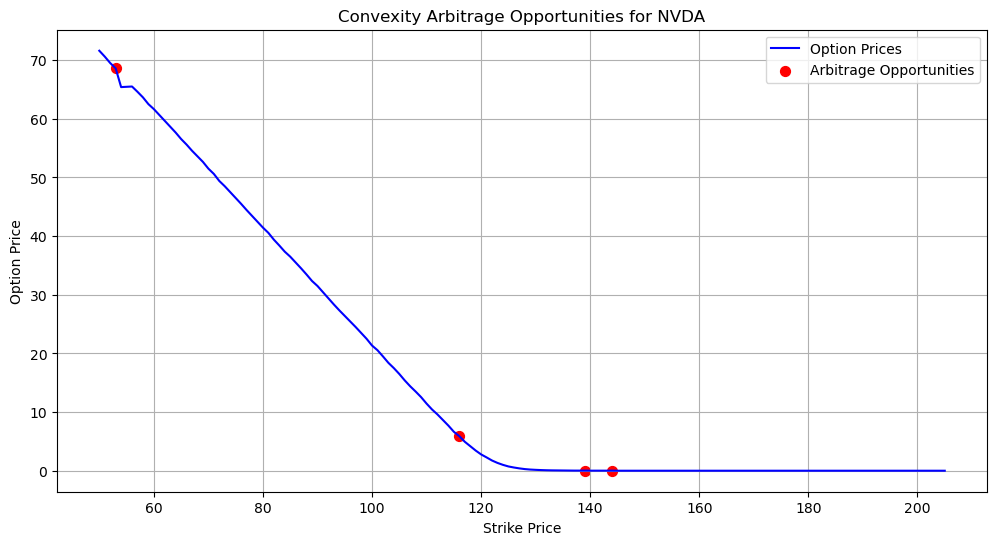

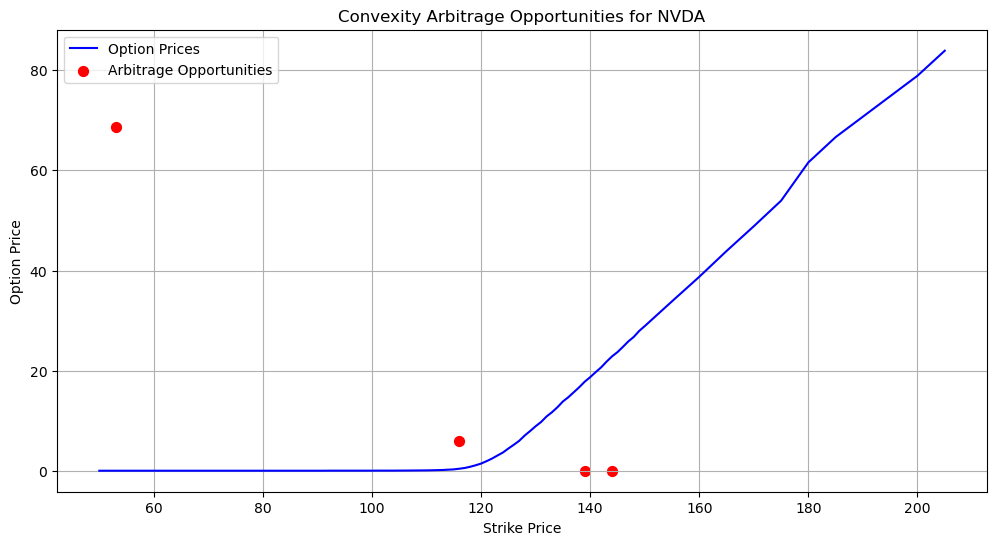

   lower_strike  middle_strike  upper_strike  expected_price  actual_price  \
0          52.0           53.0          54.0          67.450         68.60   
1         115.0          116.0         117.0           5.800          5.90   
2         138.0          139.0         140.0           0.025          0.03   
3         143.0          144.0         145.0           0.015          0.02   

   arbitrage  
0      1.150  
1      0.100  
2      0.005  
3      0.005  
   lower_strike  middle_strike  upper_strike  expected_price  actual_price  \
0          52.0           53.0          54.0          67.450         68.60   
1         115.0          116.0         117.0           5.800          5.90   
2         138.0          139.0         140.0           0.025          0.03   
3         143.0          144.0         145.0           0.015          0.02   

   arbitrage  
0      1.150  
1      0.100  
2      0.005  
3      0.005  


In [118]:
arbitrage_opportunities_call, arbitrage_opportunities_put = find_convexity_arbitrage("NVDA")
print(arbitrage_opportunities_call)
print(arbitrage_opportunities_put)